#### Prediction of missing eye tracking data with neural networks
Lucas D. Haberkamp<sup>1,2,3</sup>, Michael D. Reddix<sup>1</sup>

<sup>1</sup>Naval Medical Research Unit - Dayton  
<sup>2</sup>Oak Ridge Institute for Science and Education  
<sup>3</sup>Leidos   

---

This script trains a multi-layer perceptron to classify the gaze label from the 3D point of gaze coordinates.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from focal_loss import SparseCategoricalFocalLoss

"extractdf" is a function which reads each file as a dataframe and saves the dataframe to a list and also saves a separate list of the filenames.

In [6]:
# fill_nan should be used with classification ground truth data. prevents a nan label.
def extractdf(data_path, fill_nan=False):
    file_list, df_list = [], [] # initialize lists
    for filename in os.listdir(data_path):
        f = os.path.join(data_path, filename) 
        if os.path.isfile(f):
            current_file = os.path.splitext(filename)[0].split('_')[0] # get the identifier of the participant from the file
            file_list.append(current_file)  
            tmp_df = pd.read_csv(f)
            if fill_nan == True:
                tmp_df = tmp_df.fillna(0)
            df_list.append(tmp_df)

    return df_list, file_list

Extract the training and validation data for each file into separate lists for y_regression and y_classification, respectively.

In [7]:
# Specify paths
trainy_regression_path = '../Data/Prep/train/trainy-regression'
trainy_classification_path = '../Data/Prep/train/trainy-classification'

valy_regression_path = '../Data/Prep/validation/valy-regression'
valy_classification_path = '../Data/Prep/validation/valy-classification'

# Extract the data as dataframes stored into lists
trainy_regression_list, train_file_list = extractdf(trainy_regression_path)  
trainy_classification_list, _ = extractdf(trainy_classification_path, fill_nan=True)

valy_regression_list, val_file_list = extractdf(valy_regression_path)
valy_classification_list, _ = extractdf(valy_classification_path, fill_nan=True)

print("Files in the training dataset:", train_file_list)
print("Files in the validation dataset:", val_file_list)

Files in the training dataset: ['P01', 'P02', 'P03', 'P04', 'P05', 'P07', 'P08', 'P09', 'P11', 'P12', 'P13', 'P14']
Files in the validation dataset: ['P06', 'P10']


Intialize separate MinMaxScaler object to scale the point of gaze coordinates.

In [8]:
y_scaler = MinMaxScaler()

# fit data to the first file in the training dataset
y_scaler.fit(trainy_regression_list[0].values)

MinMaxScaler()

Prepare training and validation data by scaling with MinMaxScaler and discounting missing data.

In [9]:
# Prepare Training Data
y_reg_train = np.concatenate(trainy_regression_list, axis=0)
y_reg_train = y_scaler.transform(y_reg_train)

y_class_train = np.concatenate(trainy_classification_list, axis=0)

y_class_train = y_class_train[~np.isnan(y_reg_train[:,0])] 
y_reg_train = y_reg_train[~np.isnan(y_reg_train[:,0])] 

# Prepare Validation Data
y_reg_val = np.concatenate(valy_regression_list, axis=0)
y_reg_val = y_scaler.transform(y_reg_val)

y_class_val = np.concatenate(valy_classification_list, axis=0)

y_class_val = y_class_val[~np.isnan(y_reg_val[:,0])] 
y_reg_val = y_reg_val[~np.isnan(y_reg_val[:,0])] 

Check shapes of training and validation data.

In [10]:
print("Training-Point of Gaze Shape:", y_class_train.shape)
print("Training-Gaze Label Shape:", y_reg_train.shape)

print("\nValidation-Point of Gaze Shape:", y_class_val.shape)
print("Validation-Gaze Label Shape:", y_reg_val.shape)

Training-Point of Gaze Shape: (802393, 1)
Training-Gaze Label Shape: (802393, 3)

Validation-Point of Gaze Shape: (134042, 1)
Validation-Gaze Label Shape: (134042, 3)


In [11]:
# Check for nans in the training dataset
y_reg_train_nans = np.isnan(y_reg_train).any()
print("y_regression_train Missing values:", y_reg_train_nans)
y_class_train_nans = np.isnan(y_class_train).any()
print("y_classification_train Missing values:", y_class_train_nans)

# Check for nans in the validation dataset
y_reg_val_nans = np.isnan(y_reg_val).any()
print("y_regression_validation Missing values:", y_reg_val_nans)
y_class_val_nans = np.isnan(y_class_val).any()
print("y_classification_validation Missing values:", y_class_val_nans)

# check the number of unique classification labels
number_classes_train = np.unique(y_class_train)
print("\nAll classification labels in the training dataset:", number_classes_train)

number_classes_val = np.unique(y_class_train)
print("\nAll classification labels in the validation dataset:", number_classes_val)

y_regression_train Missing values: False
y_classification_train Missing values: False
y_regression_validation Missing values: False
y_classification_validation Missing values: False

All classification labels in the training dataset: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]

All classification labels in the validation dataset: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


In [28]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

In [29]:
# Classification Model

# input layer
inputs = Input(shape=y_reg_train.shape[1])

x = Dense(16, activation="relu")(inputs)
x = Dense(16, activation="relu")(x)

# output layer
outputs = Dense(len(number_classes_train), activation='softmax', name="classification_output")(x)

# define the Model
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 16)                64        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 classification_output (Dens  (None, 14)               238       
 e)                                                              
                                                                 
Total params: 574
Trainable params: 574
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Set training parameters for the classifier
batch_size = 256
optimizer = Adam(learning_rate=1e-3)
loss = SparseCategoricalFocalLoss(gamma=2)
metrics = 'acc'
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=10, verbose=1, restore_best_weights=True)

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [31]:
# Train the classification model
history = model.fit(y_reg_train, y_class_train,
                    validation_data=(y_reg_val, y_class_val),
                    batch_size=batch_size,
                    shuffle=True,
                    epochs=200,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/200
3135/3135 [==============================] - 4s 991us/step - loss: 0.4458 - acc: 0.8002 - val_loss: 0.0841 - val_acc: 0.9810
Epoch 2/200
3135/3135 [==============================] - 3s 911us/step - loss: 0.0648 - acc: 0.9791 - val_loss: 0.0474 - val_acc: 0.9881
Epoch 3/200
3135/3135 [==============================] - 3s 949us/step - loss: 0.0309 - acc: 0.9847 - val_loss: 0.0307 - val_acc: 0.9867
Epoch 4/200
3135/3135 [==============================] - 3s 928us/step - loss: 0.0181 - acc: 0.9894 - val_loss: 0.0165 - val_acc: 0.9916
Epoch 5/200
3135/3135 [==============================] - 3s 906us/step - loss: 0.0113 - acc: 0.9933 - val_loss: 0.0114 - val_acc: 0.9940
Epoch 6/200
3135/3135 [==============================] - 3s 904us/step - loss: 0.0086 - acc: 0.9951 - val_loss: 0.0086 - val_acc: 0.9937
Epoch 7/200
3135/3135 [==============================] - 3s 902us/step - loss: 0.0071 - acc: 0.9960 - val_loss: 0.0069 - val_acc: 0.9952
Epoch 8/200
3135/3135 [==================

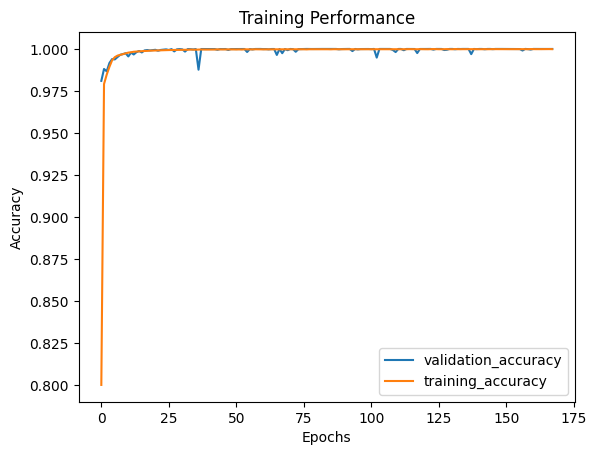

In [32]:
# Get training accuracy 
val_acc = history.history['val_acc']
acc = history.history['acc']

# Obtain number of epochs
epochs = range(len(acc))

# Plot loss and val loss
plt.plot(val_acc[0:], label='validation_accuracy')
plt.plot(acc[0:], label='training_accuracy')
plt.legend()
plt.title('Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [33]:
# Save model
model.save("../Models/Classifier")

INFO:tensorflow:Assets written to: ../Models/Classifier\assets


INFO:tensorflow:Assets written to: ../Models/Classifier\assets
